In [58]:
import os
import re
import sys
import yaml
from pathlib import Path
from typing import Union, Tuple, List, Optional
from collections.abc import Callable
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import optuna
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from utils.modelling.data import *
from utils.modelling.evaluation import *
from utils.modelling.training import *
from utils.modelling.tuning import *

## Training Retention Model

In this notebook, we will train the retention model that is used for our framework

### Read YAML File

In [59]:
# Read YAML file
config_file_path = '../config/modelling.yaml'
with open(config_file_path) as fstream:
    config = yaml.safe_load(fstream)

### Import Dataset



In [60]:
file_path = os.path.expanduser(config['pipeline']['input_data'])
df = pl.read_parquet(file_path)
df = df.drop('user_id')
df

user_id_first,device_family_linux_max,device_family_mac os x_max,device_family_windows_max,region_grouped_international_max,region_grouped_midwest_max,region_grouped_northeast_max,region_grouped_south_max,region_grouped_west_max,event_category_account & policy management_max,event_category_action center & workflow_max,event_category_dashboard & ui interactions_max,event_category_other/system events_max,event_category_session & navigation_max,event_category_submission & forms_max,uw_max,admin_max,manager_max,broker_max,google_max,microsoft_max,client_event_hour_mean,client_upload_hour_mean,event_hour_mean,server_received_hour_mean,server_upload_hour_mean,time_to_server_mean,server_to_process_mean,processing_time_mean,returned_within_7_days,session_seconds
str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i8,i8,i8,i8,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,i8,i64
"""23948c43-0a67-46af-9ac4-7c2934…",0,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,14.294521,14.369863,14.294521,14.369863,14.369863,871.828767,0.0,0.527397,1,437
"""88e62b40-bf38-4d53-9728-30184d…",0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,15.578947,14.0,15.578947,14.0,14.0,1.8971e6,0.0,0.552632,1,2699
"""897ef84b-cbc9-4c72-8bff-d35bfd…",0,0,1,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,7.386207,7.372414,7.386207,7.372414,7.372414,857.77931,0.0,0.6,1,7104
"""2960eb27-039a-4489-94eb-670e48…",0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,16.0,16.0,16.0,16.0,16.0,2.482759,0.0,6.862069,0,126
"""9cadb195-5205-414d-bac7-3d96d2…",0,0,1,0,0,0,1,0,1,1,1,0,1,1,1,0,0,0,0,0,9.45781,9.48833,9.45781,9.48833,9.48833,733.199282,0.0,5.971275,1,16858
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""abe2a8ce-bdc7-4dfb-be98-2d8802…",0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,14.0,14.0,14.0,14.0,14.0,3.866667,0.0,1.766667,1,647
"""27f310fe-0840-488c-a98f-d5083d…",0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,18.946996,17.0,18.946996,17.0,17.0,1.3732e7,0.0,0.713781,1,9262
"""dc56ed4b-87e2-4c13-85b0-5e11f1…",0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,9.378151,4.0,9.378151,4.0,4.0,3.1772e6,0.0,0.369748,1,20182


### Split Data into Sets

In [61]:
# Split data into training, validation, and test sets
df_train, df_val, df_test = group_train_validation_split(df, 'user_id_first', random_state = 42)
df_train

device_family_linux_max,device_family_mac os x_max,device_family_windows_max,region_grouped_international_max,region_grouped_midwest_max,region_grouped_northeast_max,region_grouped_south_max,region_grouped_west_max,event_category_account & policy management_max,event_category_action center & workflow_max,event_category_dashboard & ui interactions_max,event_category_other/system events_max,event_category_session & navigation_max,event_category_submission & forms_max,uw_max,admin_max,manager_max,broker_max,google_max,microsoft_max,client_event_hour_mean,client_upload_hour_mean,event_hour_mean,server_received_hour_mean,server_upload_hour_mean,time_to_server_mean,server_to_process_mean,processing_time_mean,returned_within_7_days,session_seconds
u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i8,i8,i8,i8,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,i8,i64
0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,16.0,4.0,16.0,4.0,4.0,5.484906e6,0.0,0.884615,1,1056
0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,16.270833,16.270833,16.270833,16.270833,16.270833,0.9375,0.0,0.291667,1,1829
0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,15.404762,15.404762,15.404762,15.404762,15.404762,1.154762,0.0,1.107143,1,4405
0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,18.478261,18.5,18.478261,18.5,18.5,1957.5,0.0,1.043478,1,51
0,0,1,0,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,17.821053,15.0,17.821053,15.0,15.0,1.5436e6,0.0,1.368421,1,6636
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,2.590361,2.60241,2.590361,2.60241,2.60241,26.710843,0.0,0.903614,1,9032
0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,16.5,16.5,16.5,16.5,16.5,4315.25,0.0,1.55,1,35
0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,18.0,4.0,18.0,4.0,4.0,2973858.6,0.0,0.0,1,193


### Split Data to X and y Sets

In [62]:
# Split each set into relevant X and y data
train_validation_split = TrainValidationSplit(val_ratio = 0.1, random_state = 42)
X_train, y_train = train_validation_split.X_y_split(df_train, 'returned_within_7_days')
X_val, y_val = train_validation_split.X_y_split(df_val, 'returned_within_7_days')
X_test, y_test = train_validation_split.X_y_split(df_test, 'returned_within_7_days')

### Initialize Trainer

In [63]:
# Initialize trainer and dataloader
dataloader = Dataloader(batch_size = 500000)
trainer = Trainer(XGBClassifier, dataloader)

### Training Initial Model

In [64]:
# Initialize trainer and dataloader
trainer = Trainer(XGBClassifier, dataloader)

# Set evaluation set parameter 
eval_set = [(X_train, y_train), (X_val, y_val)]

# Specify default parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42
}

# Train the model
model = XGBClassifier(**params)
model.fit(X_train, y_train, eval_set = eval_set)

[0]	validation_0-logloss:0.26037	validation_1-logloss:0.27231
[1]	validation_0-logloss:0.23710	validation_1-logloss:0.25146
[2]	validation_0-logloss:0.22074	validation_1-logloss:0.23686
[3]	validation_0-logloss:0.20807	validation_1-logloss:0.22642
[4]	validation_0-logloss:0.19902	validation_1-logloss:0.21906
[5]	validation_0-logloss:0.19266	validation_1-logloss:0.21470
[6]	validation_0-logloss:0.18806	validation_1-logloss:0.21137
[7]	validation_0-logloss:0.18457	validation_1-logloss:0.20903
[8]	validation_0-logloss:0.18170	validation_1-logloss:0.20787
[9]	validation_0-logloss:0.17951	validation_1-logloss:0.20630
[10]	validation_0-logloss:0.17763	validation_1-logloss:0.20528
[11]	validation_0-logloss:0.17603	validation_1-logloss:0.20444
[12]	validation_0-logloss:0.17434	validation_1-logloss:0.20491
[13]	validation_0-logloss:0.17297	validation_1-logloss:0.20512
[14]	validation_0-logloss:0.17136	validation_1-logloss:0.20408
[15]	validation_0-logloss:0.17015	validation_1-logloss:0.20387
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

### Evaluate Initial Model

Validation Set Metrics:
Accuracy:
0.9222372132957194
F1:
0.9580354778925073
AUC:
0.8726578976578976
Confusion Matrix:
[[ 282  446]
 [ 188 7237]]
Plotting Learning Curve:


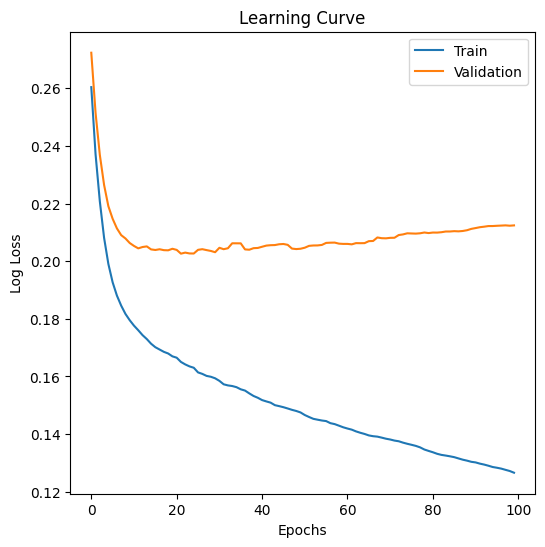

Plotting Feature Importance:


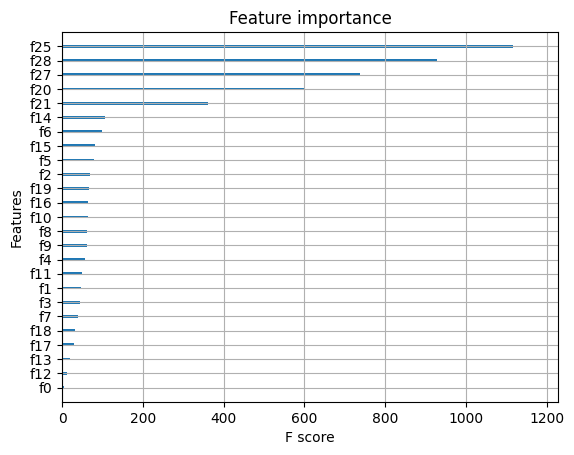

Plotting Shuffling Feature Importance:


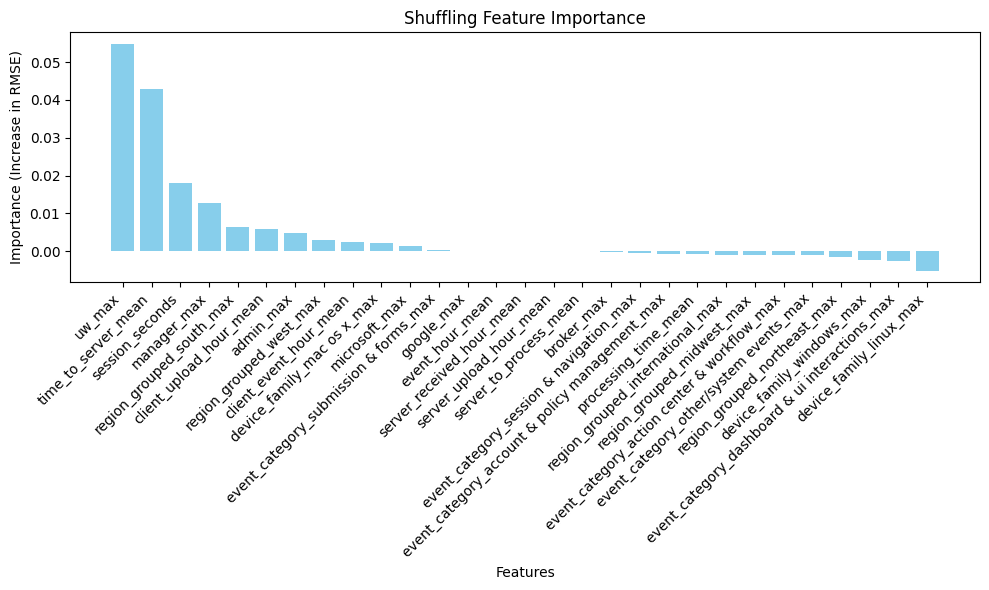

Feature,Importance
str,f64
"""uw_max""",0.054862
"""time_to_server_mean""",0.042886
"""session_seconds""",0.018106
"""manager_max""",0.012897
"""region_grouped_south_max""",0.006306
…,…
"""event_category_other/system ev…",-0.000881
"""region_grouped_northeast_max""",-0.001544
"""device_family_windows_max""",-0.002208


In [65]:
eval_classifier = ClassificationEvaluation(model)

print("Validation Set Metrics:")
eval_classifier.get_classification_metrics(X_val, y_val)


print("Plotting Learning Curve:")
eval_classifier.plot_learning_curve()

print("Plotting Feature Importance:")
eval_classifier.plot_xgb_feature_importance()

print("Plotting Shuffling Feature Importance:")
eval_classifier.shuffling_feature_importance(X_val, y_val)

### Get Random Feature Importance

We can train our model with a random-valued column to see what columns is worth dropping.

If a column performs worse than random values, then it is fair to drop them from our feature set

In [92]:
# Get random feature importance
def get_random_feature_importance(model, X_train, y_train):

    # Get feature importance
    rng = np.random.RandomState(42)
    X_train = X_train.with_columns(pl.Series('random', rng.randn(X_train.shape[0], 1,).flatten()))
    model.fit(X_train, y_train)
    feature_importance = model.get_booster().get_score(importance_type = 'gain')

    # Map back to columns
    feature_map = {f"f{i}": col for i, col in enumerate(X_train.columns)}
    renamed_importance_dict = {feature_map[k]: v for k, v in feature_importance.items()}
    sorted_importance_dict = dict(sorted(renamed_importance_dict.items(), key=lambda item: item[1], reverse=True))

    return sorted_importance_dict


def get_unimportant_columns(model, X_train, y_train):
    sorted_importance_dict = get_random_feature_importance(model, X_train, y_train)
    return [key for key, val in sorted_importance_dict.items() if val < sorted_importance_dict['random']]



In [93]:
# Get random feature importance
random_feature_importance = get_random_feature_importance(model, X_train, y_train)
random_feature_importance

{'manager_max': 61.219947814941406,
 'uw_max': 31.235431671142578,
 'admin_max': 27.539512634277344,
 'session_seconds': 16.814374923706055,
 'device_family_windows_max': 15.156549453735352,
 'event_category_action center & workflow_max': 13.271136283874512,
 'region_grouped_south_max': 10.192100524902344,
 'time_to_server_mean': 9.833085060119629,
 'microsoft_max': 6.511285305023193,
 'device_family_linux_max': 6.3780035972595215,
 'event_category_account & policy management_max': 5.160314559936523,
 'region_grouped_international_max': 4.99761962890625,
 'device_family_mac os x_max': 4.985256195068359,
 'event_category_dashboard & ui interactions_max': 4.928468227386475,
 'google_max': 4.435153484344482,
 'broker_max': 4.415560245513916,
 'client_upload_hour_mean': 4.170676231384277,
 'event_category_other/system events_max': 3.9947516918182373,
 'client_event_hour_mean': 3.8763234615325928,
 'region_grouped_northeast_max': 3.8658037185668945,
 'event_category_submission & forms_max':

In [94]:
# Get unimportant columns
df = df.drop(get_unimportant_columns(model, X_train, y_train))
df

user_id_first,device_family_linux_max,device_family_mac os x_max,device_family_windows_max,region_grouped_international_max,region_grouped_midwest_max,region_grouped_northeast_max,region_grouped_south_max,region_grouped_west_max,event_category_account & policy management_max,event_category_action center & workflow_max,event_category_dashboard & ui interactions_max,event_category_other/system events_max,event_category_submission & forms_max,uw_max,admin_max,manager_max,broker_max,google_max,microsoft_max,client_event_hour_mean,client_upload_hour_mean,event_hour_mean,server_received_hour_mean,server_upload_hour_mean,time_to_server_mean,server_to_process_mean,processing_time_mean,returned_within_7_days,session_seconds
str,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,u8,i8,i8,i8,i8,i32,i32,f64,f64,f64,f64,f64,f64,f64,f64,i8,i64
"""23948c43-0a67-46af-9ac4-7c2934…",0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,14.294521,14.369863,14.294521,14.369863,14.369863,871.828767,0.0,0.527397,1,437
"""88e62b40-bf38-4d53-9728-30184d…",0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,15.578947,14.0,15.578947,14.0,14.0,1.8971e6,0.0,0.552632,1,2699
"""897ef84b-cbc9-4c72-8bff-d35bfd…",0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,7.386207,7.372414,7.386207,7.372414,7.372414,857.77931,0.0,0.6,1,7104
"""2960eb27-039a-4489-94eb-670e48…",0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,16.0,16.0,16.0,16.0,16.0,2.482759,0.0,6.862069,0,126
"""9cadb195-5205-414d-bac7-3d96d2…",0,0,1,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,0,9.45781,9.48833,9.45781,9.48833,9.48833,733.199282,0.0,5.971275,1,16858
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""abe2a8ce-bdc7-4dfb-be98-2d8802…",0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,14.0,14.0,14.0,14.0,14.0,3.866667,0.0,1.766667,1,647
"""27f310fe-0840-488c-a98f-d5083d…",0,0,1,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,0,18.946996,17.0,18.946996,17.0,17.0,1.3732e7,0.0,0.713781,1,9262
"""dc56ed4b-87e2-4c13-85b0-5e11f1…",0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,0,9.378151,4.0,9.378151,4.0,4.0,3.1772e6,0.0,0.369748,1,20182


### Hyperparammter Tuning

In [95]:
target_col = "returned_within_7_days"

# Split data
df_train, df_val, df_test = group_train_validation_split(df, 'user_id_first', random_state = 42)
train_validation_split = TrainValidationSplit(val_ratio = 0.01, random_state = None)

X_train, y_train = train_validation_split.X_y_split(df_train, target_col)
X_val, y_val = train_validation_split.X_y_split(df_val, target_col)
X_test, y_test = train_validation_split.X_y_split(df_test, target_col)

# Define Objective Function for Optuna
def objective(trial):

    # Specify params
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "lambda": trial.suggest_float("lambda", 0, 5),
        "alpha": trial.suggest_float("alpha", 0, 5),
        "objective": "binary:logistic",  
        "eval_metric": "logloss", 
        "random_state": 42,
    }

    # Train Model
    model = xgb.XGBClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    # Predict Probabilities
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Compute Log Loss (Minimization Objective)
    return log_loss(y_val, y_pred_proba)

# Run Optuna Optimization
study = optuna.create_study(direction="minimize")  # We minimize log loss
study.optimize(objective, n_trials=100)  # Adjust the number of trials for better results

# Print Best Parameters
print("Best Hyperparameters:", study.best_params)


[I 2025-02-24 23:30:14,203] A new study created in memory with name: no-name-4df7be9d-5e15-414d-a0c4-5e7688e0167b


[I 2025-02-24 23:30:14,969] Trial 0 finished with value: 0.22334684994890647 and parameters: {'max_depth': 6, 'learning_rate': 0.10278440772407159, 'n_estimators': 452, 'min_child_weight': 6, 'subsample': 0.5393200733818975, 'colsample_bytree': 0.6371255918797998, 'gamma': 4.203441418698427, 'lambda': 1.625122238807812, 'alpha': 0.8330366755075552}. Best is trial 0 with value: 0.22334684994890647.
[I 2025-02-24 23:30:15,312] Trial 1 finished with value: 0.22602062426358205 and parameters: {'max_depth': 7, 'learning_rate': 0.19096988061060002, 'n_estimators': 280, 'min_child_weight': 4, 'subsample': 0.8741951246537067, 'colsample_bytree': 0.839774197782094, 'gamma': 4.333151529817744, 'lambda': 0.5718987749163013, 'alpha': 4.611666477248327}. Best is trial 0 with value: 0.22334684994890647.
[I 2025-02-24 23:30:15,729] Trial 2 finished with value: 0.22976288443047635 and parameters: {'max_depth': 4, 'learning_rate': 0.2469370375593966, 'n_estimators': 395, 'min_child_weight': 3, 'subsamp

Best Hyperparameters: {'max_depth': 9, 'learning_rate': 0.041121986974301104, 'n_estimators': 405, 'min_child_weight': 8, 'subsample': 0.6501356528982457, 'colsample_bytree': 0.9338847673801949, 'gamma': 2.2059142306660826, 'lambda': 2.3547134034243475, 'alpha': 4.1831022147314}


In [96]:
# Train Final Model with Best Parameters
best_params = study.best_params
final_model = xgb.XGBClassifier(**best_params)
eval_set = [(X_train, y_train), (X_val, y_val)]
final_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Make Predictions on Test Set
y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Evaluate Model Performance
accuracy = accuracy_score(y_test, y_test_pred)
logloss = log_loss(y_test, y_test_pred_proba)
auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"Final Model Accuracy: {accuracy:.4f}")
print(f"Final Log Loss: {logloss:.4f}")
print(f"Final AUC Score: {auc:.4f}")

Final Model Accuracy: 0.9141
Final Log Loss: 0.2390
Final AUC Score: 0.8809


Validation Set Metrics:
Accuracy:
0.9201501229455157
F1:
0.9571617024231063
AUC:
0.8780211914984102
Confusion Matrix:
[[ 217  572]
 [  45 6893]]

Test Set Metrics:
Accuracy:
0.9140568099053168
F1:
0.9530703149856825
AUC:
0.8809472437511954
Confusion Matrix:
[[ 284  532]
 [  58 5991]]

Plotting ROC Curve for Test Set:


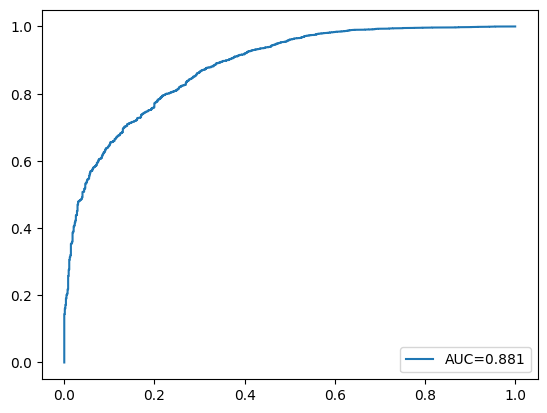

Plotting Learning Curve:


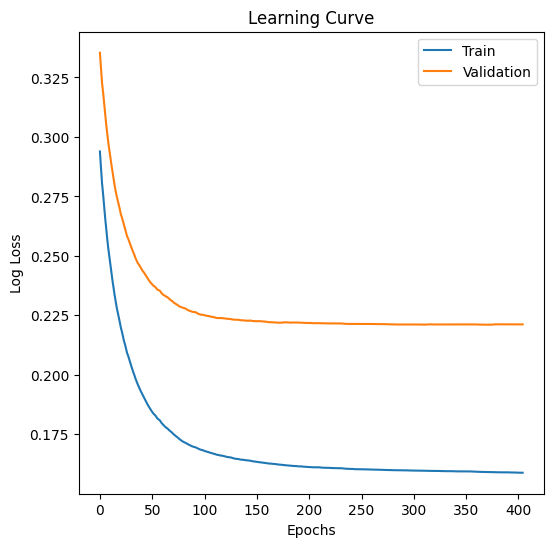

Plotting Feature Importance:


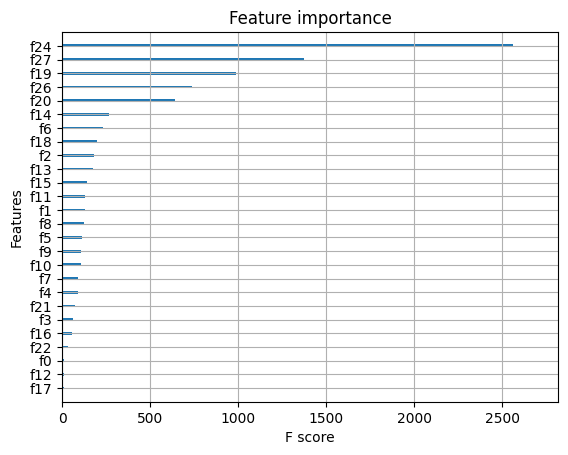

Plotting Shuffling Feature Importance:


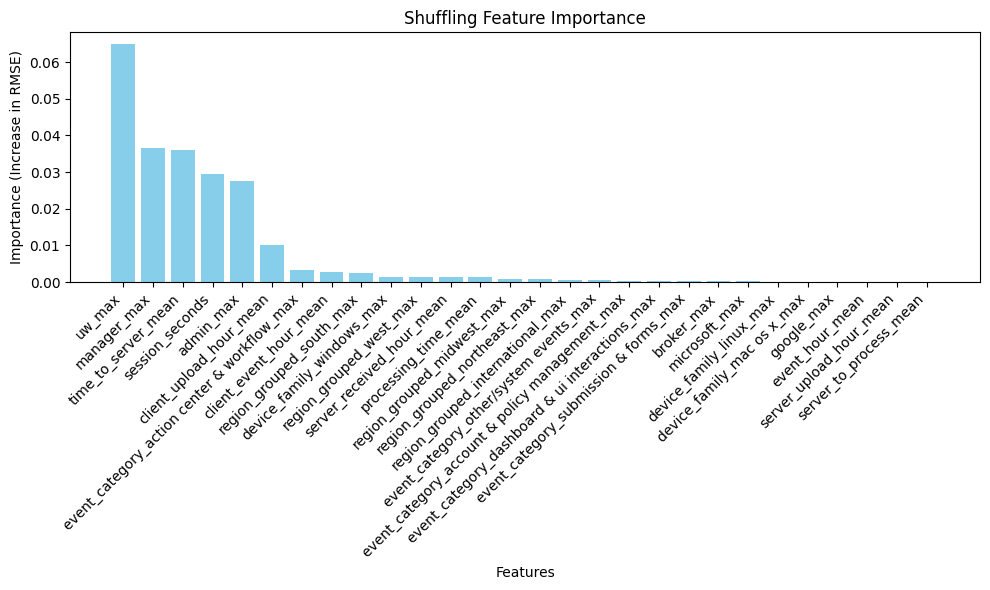

Feature,Importance
str,f64
"""uw_max""",0.064871
"""manager_max""",0.036486
"""time_to_server_mean""",0.036044
"""session_seconds""",0.029339
"""admin_max""",0.027527
…,…
"""device_family_mac os x_max""",0.0
"""google_max""",0.0
"""event_hour_mean""",0.0


In [98]:
eval_classifier = ClassificationEvaluation(final_model)

print("Validation Set Metrics:")
eval_classifier.get_classification_metrics(X_val, y_val)

print("\nTest Set Metrics:")
eval_classifier.get_classification_metrics(X_test, y_test)

print("\nPlotting ROC Curve for Test Set:")
eval_classifier.plot_roc_curve(X_test, y_test)

print("Plotting Learning Curve:")
eval_classifier.plot_learning_curve()

print("Plotting Feature Importance:")
eval_classifier.plot_xgb_feature_importance()

print("Plotting Shuffling Feature Importance:")
eval_classifier.shuffling_feature_importance(X_test, y_test)

In [102]:
import pickle

# Define the filename for saving the model
model_filename = os.path.expanduser('~/Desktop/data/xgb_classifier.pkl')

# Save the model using pickle
with open(model_filename, "wb") as file:
    pickle.dump(final_model, file)

print(f"Model saved successfully as {model_filename}")


Model saved successfully as /Users/tung/Desktop/data/xgb_classifier.pkl
